### Problem statement
1. Determine the train arrivals based on the transition time events of wifi signals at the respective stations.
2. I have formulated it as an unsupervised ML problem since the dataset is unlabelled.
3. The ground truth data is used to ascertain to things:-
    1. The number of train arrivals in each station in the time period.
    2. The schedule of the arrivals of the first and last trains in each of the stops.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()

### Load the events dataset

In [2]:
train_data = pd.read_csv("train_detection_challenge/transition_events.csv")
train_data.sort_values(["to_stop", "arrival_ts"], inplace=True)
train_data["travel_time"] = train_data["arrival_ts"]-train_data["departure_ts"]
print(train_data.shape)
train_data.head()

(37716, 6)


,from_stop,to_stop,departure_ts,arrival_ts,user_id,travel_time
1419,A,B,-41,0,868462956041125229,41
1420,A,B,-57,0,-7108464334138306488,57
1421,A,B,-75,5,-5580035554712257388,80
1422,A,B,-45,5,8609463184398044933,50
1423,A,B,-55,7,-864327616201632446,62


In [3]:
train_data.to_stop.value_counts()

C    23280
B    14436
Name: to_stop, dtype: int64

### Load the train arrivals ground truth
Determine the first and last arrivals

In [4]:
ground_truth=pd.read_csv("train_detection_challenge/train_arrival_times.csv")
ground_truth.sort_values(["stop","arrival_ts"],inplace=True)
print(ground_truth.shape)

(320, 2)


In [5]:
def get_min_max_arrival_ts(group):
    ret = {}
    ret["max_arrival_ts"] = group["arrival_ts"].max()
    ret["min_arrival_ts"] = group["arrival_ts"].min()
    ret["num_of_arrivals"] = len(group["arrival_ts"])
    return pd.Series(ret)


stats_ground = ground_truth.groupby("stop").apply(get_min_max_arrival_ts)
stats_ground.reset_index(inplace=True)
stats_ground

,stop,max_arrival_ts,min_arrival_ts,num_of_arrivals
0,B,34985,300,160
1,C,35131,434,160


### Remove outlier travel times
This indicates that these devices are not travelling by the train from the origin to destinations stations. I am filtering out all travel times greater than p95 for all OD stops.

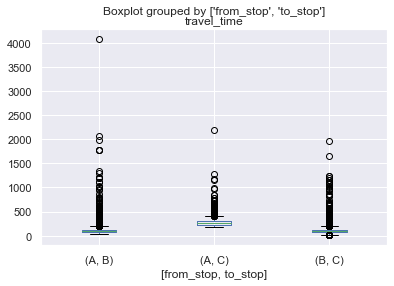

In [6]:
fig, ax = plt.subplots()
train_data.boxplot(
    column=['travel_time'], by=['from_stop', 'to_stop'], ax=ax)

In [7]:
def get_quantiles(group):
    return group["travel_time"].quantile([.05,0.95,0.99])

train_data.groupby(["from_stop", "to_stop"]).apply(get_quantiles)

travel_time         0.05   0.95    0.99
from_stop to_stop                      
A         B         56.0  176.0  369.65
          C        196.0  419.6  648.00
B         C          4.0  169.0  264.00

In [8]:
train_data.drop(train_data[((train_data.from_stop == "A") & (
    train_data.to_stop == "B")) & ((train_data.travel_time > 176))].index, inplace=True)

train_data.drop(train_data[((train_data.from_stop == "B") & (
    train_data.to_stop == "C")) &
    ((train_data.travel_time > 169) | (train_data.travel_time <= 4))].index,  inplace=True)

train_data.drop(train_data[((train_data.from_stop == "A") & (
    train_data.to_stop == "C")) & ((train_data.travel_time > 420))].index,  inplace=True)
print(train_data.shape)

(34570, 6)


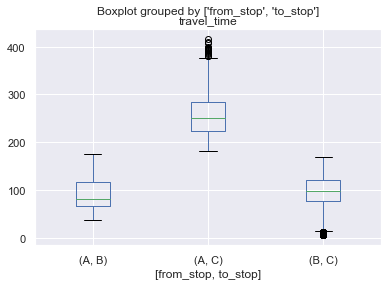

In [9]:
fig, ax = plt.subplots()
train_data.boxplot(
    column=['travel_time'], by=['from_stop','to_stop'], ax=ax)

### Remove departure_ts outliers
* departure_ts cannot be greater than the maximum arrival_ts for the stop.
* I am filtering out departure_ts<0

In [10]:
train_data.drop(train_data[(train_data.to_stop == "B") &
(train_data.departure_ts > 34985)].index, inplace=True)

train_data.drop(train_data[(train_data.to_stop == "C") &
(train_data.departure_ts > 35131)].index, inplace=True)
train_data = train_data[train_data.departure_ts > 0]
train_data.shape

(34453, 6)

### EDA on ground truth data

In [11]:
ground_truth_B = ground_truth[ground_truth.stop == "B"].copy()
ground_truth_C = ground_truth[ground_truth.stop == "C"].copy()

In [12]:
ground_truth_C["next"]=ground_truth_C.arrival_ts.shift(-1)
ground_truth_C["IAT"]=ground_truth_C["next"]-ground_truth_C["arrival_ts"]

ground_truth_B["next"]=ground_truth_B.arrival_ts.shift(-1)
ground_truth_B["IAT"]=ground_truth_B["next"]-ground_truth_B["arrival_ts"]


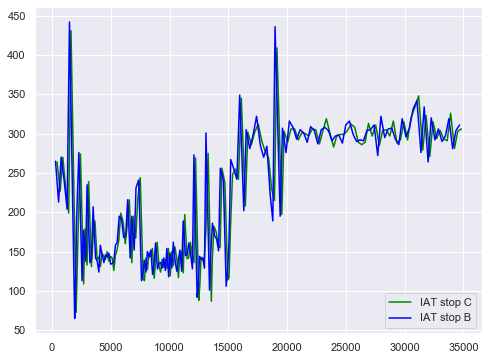

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ground_truth_C["arrival_ts"],ground_truth_C["IAT"],color='green',label="IAT stop C")
ax.plot(ground_truth_B["arrival_ts"],ground_truth_B["IAT"],color='blue',label="IAT stop B")
plt.legend(loc=4)
plt.draw()

### Evaluating model performance

In [14]:
def metrics(y_true, y_pred):
    """
    I asess the accuarcy of the model based on the 4 metrics below, MAPE, RMSE,
    Mean absolute error and Mean bias
    """
    ape = np.abs(y_true-y_pred)/y_true
    ape = ape[ape < np.percentile(ape, 99)]
    print("MAPE", ape.mean())

    sq_error = (y_true-y_pred) ** 2
    sq_error = sq_error[sq_error < np.percentile(sq_error, 99)]
    print("RMSE:", np.sqrt(sq_error.mean()))

    abs_error = abs(y_true-y_pred)
    abs_error = abs_error[abs_error <
                                  np.percentile(abs_error, 99)]
    print("Mean absolute error:", abs_error.mean())

    # bias
    bias = y_true-y_pred
    bias = bias[bias < np.percentile(bias, 99)]
    print("Mean Bias", bias.mean())

In [19]:
arrivals_B = train_data[train_data.to_stop == "B"].arrival_ts
arrivals_C = train_data[train_data.to_stop == "C"].arrival_ts

### Fit K means

In [ ]:
def elbow_plot_kmeans(data, dataset_name, K=range(155, 175)):
    Sum_of_squared_distances = []

    for k in tqdm(K):
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title(f'Elbow Method For Optimal k {dataset_name}')
    plt.show()

#### Train the KMeans model for stop B

In [ ]:
elbow_plot_kmeans(np.array(arrivals_B).reshape(-1,1),"Arrivals B")


In [ ]:
data_arrivals_B = np.array(arrivals_B).reshape(-1, 1)
km = KMeans(n_clusters=160)
km = km.fit(data_arrivals_B)
cluster_centers_B = list(km.cluster_centers_.reshape(-1,))
cluster_centers_B.sort()

In [ ]:
ground_truth_B["predicted_arrival"]=cluster_centers_B
metrics(ground_truth_B["arrival_ts"], ground_truth_B["predicted_arrival"])

In [ ]:
ground_truth_B["diff"] = ground_truth_B["arrival_ts"] - \
    ground_truth_B["predicted_arrival"]
ax=sns.lineplot("arrival_ts", "diff", data=ground_truth_B)
title=ax.set_title("Errors in arrival_ts for stop B (KMeans)")

#### Train the KMeans for stop C

In [ ]:
elbow_plot_kmeans(np.array(arrivals_C).reshape(-1, 1),
                  "Arrivals C")

In [ ]:
data_arrivals_C = np.array(arrivals_C).reshape(-1, 1)
km = KMeans(n_clusters=161)
km = km.fit(data_arrivals_C)
cluster_centers_C = list(km.cluster_centers_.reshape(-1,))
cluster_centers_C.sort()

In [ ]:
ground_truth_C["predicted_arrival"]=cluster_centers_C[1:]
metrics(ground_truth_C["arrival_ts"], ground_truth_C["predicted_arrival"])

In [ ]:
ground_truth_C["diff"] = ground_truth_C["arrival_ts"] - \
    ground_truth_C["predicted_arrival"]
ax = sns.lineplot("arrival_ts", "diff", data=ground_truth_C)
title = ax.set_title("Errors in arrival_ts for stop C (KMeans)")

### Fit DBSCAN
I think Density based clustering is a good idea to try since it is more resilient to noise and outliers since it takes into account the density of the data points. This is critical in our use case since arrival events tend to cluster around the actual arrival of a train.

Choosing the model hyper parameters is tricky

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [16]:
def train_DBSCAN(arrivals_ts, eps, min_samples=20):

    def get_cluster_mean(group):
        cluster_center = group["arrival_ts"].mean()
        return pd.Series({"cluster_center": cluster_center})

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(
        np.array(arrivals_ts).reshape(-1, 1))
    cluster_labels = list(clustering.labels_)
    result = pd.DataFrame(
        {"arrival_ts": arrivals_ts, "cluster_labels": cluster_labels})
    result_clustering = result.groupby("cluster_labels").apply(
        get_cluster_mean)
    result_clustering.reset_index(inplace=True)
    return result_clustering

In [17]:
def generate_result_DBScan(ground_truth, predictions, stop_name):
    result = pd.DataFrame({"arrival_ts": list(ground_truth),
                           "predicted_arrival": list(predictions)})
    result["diff"] = result["arrival_ts"] - result["predicted_arrival"]
    return result

In [20]:
result_clustering_stop_B = train_DBSCAN(arrivals_B, eps=30)
resultDF_B = generate_result_DBScan(ground_truth[ground_truth.stop == "B"]["arrival_ts"],
                                    result_clustering_stop_B.iloc[1:, 1], "B")

MAPE 0.00010873672540638276
RMSE: 1.9610889317785478
Mean absolute error: 0.8310259766073097
Mean Bias 0.3485601866774481
None
Worst case prediction error for stop B is 61.21428571428578 time units


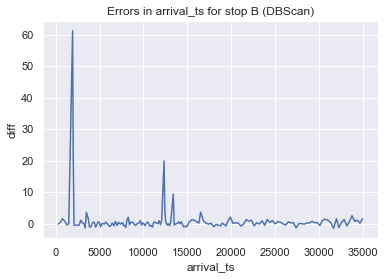

In [21]:
print(metrics(resultDF_B["arrival_ts"], resultDF_B["predicted_arrival"]))
ax = sns.lineplot("arrival_ts", "diff", data=resultDF_B)
title = ax.set_title("Errors in arrival_ts for stop B (DBScan)")
worst_error=np.abs(resultDF_B["diff"]).max()
print(f"Worst case prediction error for stop B is {worst_error} time units")

In [22]:
result_clustering_stop_C = train_DBSCAN(arrivals_C, eps=16, min_samples=23)
resultDF_C = generate_result_DBScan(ground_truth[ground_truth.stop == "C"]["arrival_ts"],
                                    result_clustering_stop_C.iloc[2:, 1], "C")

MAPE 0.0003583649374715691
RMSE: 3.324719903993859
Mean absolute error: 2.4625499748326116
Mean Bias -0.25979666435044907
None
Worst case prediction error for stop C is 28.545454545454504 time units


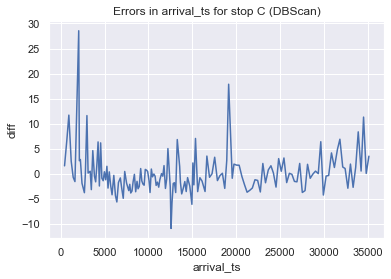

In [23]:
print(metrics(resultDF_C["arrival_ts"], resultDF_C["predicted_arrival"]))
ax = sns.lineplot("arrival_ts", "diff", data=resultDF_C)
title = ax.set_title("Errors in arrival_ts for stop C (DBScan)")

worst_error=np.abs(resultDF_C["diff"]).max()
print(f"Worst case prediction error for stop C is {worst_error} time units")

### Conclusions
* The density based clustering method proved to be more successful in clustering the arrival events in comparison to the Kmeans clustering method despite choosing the number of clusters based on the elbow plot.
* The DBScan was trickier to train since the number of clusters has to be exactly 160 for predicting the number of train arrivals in each of the stations B and C.
* The hyperparameters of DBScan were chosen in such a way to ensure that the number of clusters were 160 for station B and 161 for station C. The top most cluster for station C was ignored.